In [1]:
%matplotlib inline

In [2]:
from galsize_models.measurements import load_umachine_sdss_with_meert15
full_sdss, behroozi_complete = load_umachine_sdss_with_meert15()
no_data_mask = np.isnan(full_sdss['Magr_tot_meert15'])

mask = ~no_data_mask & behroozi_complete
sdss = full_sdss[mask]

from galsize_models.models.load_baseline_catalogs import load_umachine_mock
mock = load_umachine_mock()

mask_sf = sdss['ssfr'] >= -10.75
mask_gv = (sdss['ssfr'] < -10.75) & (sdss['ssfr'] >= -11.25)
mask_q = (sdss['ssfr'] < -11.25)

mock['is_main_sequence'] = mock['ssfr'] >= -10.75
mock['is_green_valley'] = (mock['ssfr'] < -10.75) & (mock['ssfr'] >= -11.25)
mock['is_quenched'] = (mock['ssfr'] < -11.25)
mock['logsm'] = np.log10(mock['obs_sm'])

Total runtime = 0.42 seconds


In [3]:
from galsize_models.models.bulge_disk_double_power_law import data_vector_prediction
from galsize_models.measurements.sdss_covariance import logsm_bins, logsm_mids

norm1, norm2, alpha1, alpha2, scatter = 0.0125, 0.075, 1, 0.7, 0.2
params = norm1, norm2, alpha1, alpha2, scatter
model_data_vector = data_vector_prediction(params, mock, logsm_bins)

In [4]:
from galsize_models.measurements.sdss_covariance import sdss_measurements_and_cov
sdss_data_vector, sdss_cov = sdss_measurements_and_cov()

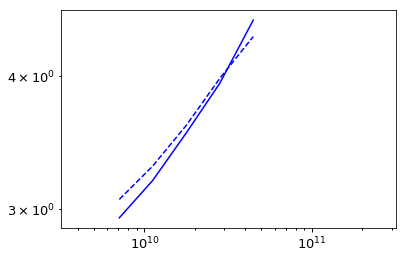

In [5]:
from galsize_models.measurements.sdss_covariance import _get_ifirst_ilast_indices

fig, ax = plt.subplots(1, 1)

__=ax.loglog()

ifirst, ilast = _get_ifirst_ilast_indices(0)
nskip = ilast-ifirst
__=ax.plot(10**logsm_mids[:nskip], sdss_data_vector[ifirst:ilast], color='blue')
__=ax.plot(10**logsm_mids[:nskip], model_data_vector[ifirst:ilast], '--', color='blue')
xlim = ax.set_xlim(10**9.5, 10**11.5)

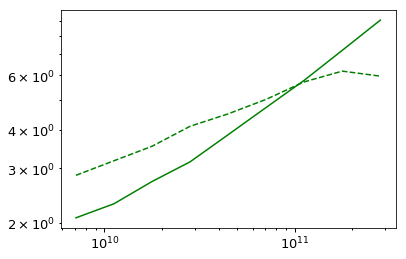

In [6]:
fig, ax = plt.subplots(1, 1)

npts = len(logsm_mids)

__=ax.loglog()

ifirst, ilast = _get_ifirst_ilast_indices(1)
nskip = ilast-ifirst
__=ax.plot(10**logsm_mids[:nskip], sdss_data_vector[ifirst:ilast], color='green')
__=ax.plot(10**logsm_mids[:nskip], model_data_vector[ifirst:ilast], '--', color='green')


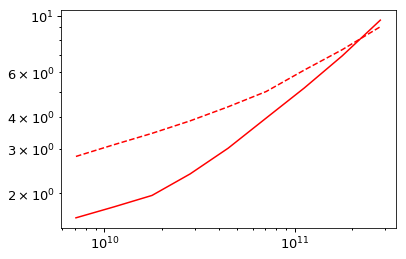

In [10]:
fig, ax = plt.subplots(1, 1)

npts = len(logsm_mids)

__=ax.loglog()

ifirst, ilast = _get_ifirst_ilast_indices(2)
nskip = ilast-ifirst
__=ax.plot(10**logsm_mids[:nskip], sdss_data_vector[ifirst:ilast], color='red')
__=ax.plot(10**logsm_mids[:nskip], model_data_vector[ifirst:ilast], '--', color='red')


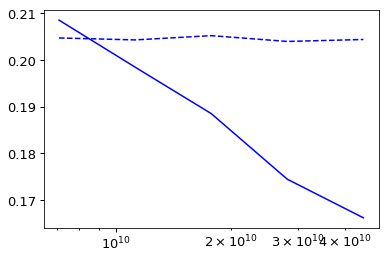

In [11]:
fig, ax = plt.subplots(1, 1)

npts = len(logsm_mids)

xscale = ax.set_xscale('log')

ifirst, ilast = _get_ifirst_ilast_indices(3)
nskip = ilast-ifirst
__=ax.plot(10**logsm_mids[:nskip], sdss_data_vector[ifirst:ilast], color='blue')
__=ax.plot(10**logsm_mids[:nskip], model_data_vector[ifirst:ilast], '--', color='blue')


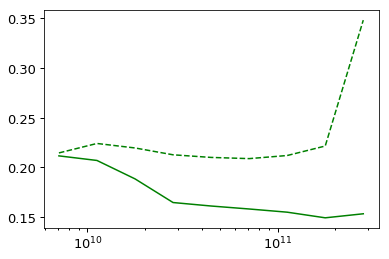

In [13]:
fig, ax = plt.subplots(1, 1)

npts = len(logsm_mids)

xscale = ax.set_xscale('log')

ifirst, ilast = _get_ifirst_ilast_indices(4)
nskip = ilast-ifirst
__=ax.plot(10**logsm_mids[:nskip], sdss_data_vector[ifirst:ilast], color='green')
__=ax.plot(10**logsm_mids[:nskip], model_data_vector[ifirst:ilast], '--', color='green')


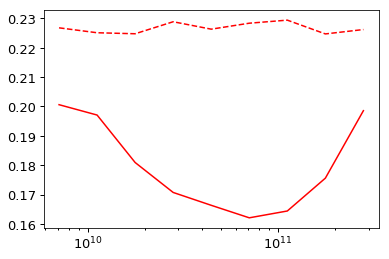

In [14]:
fig, ax = plt.subplots(1, 1)

npts = len(logsm_mids)

xscale = ax.set_xscale('log')

ifirst, ilast = _get_ifirst_ilast_indices(5)
nskip = ilast-ifirst
__=ax.plot(10**logsm_mids[:nskip], sdss_data_vector[ifirst:ilast], color='red')
__=ax.plot(10**logsm_mids[:nskip], model_data_vector[ifirst:ilast], '--', color='red')
